In [2]:
import numpy as np
import matplotlib.pyplot as plt

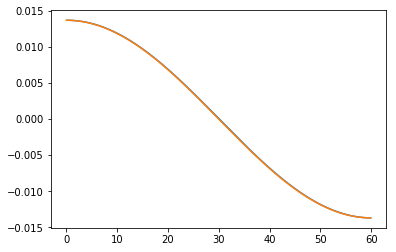

In [61]:
TOTAL_DISTANCE = 10 # meters 

TOTAL_SECONDS = 60 # seconds
SAMPLING_RATE = 10  # Hz
dt = 1 / SAMPLING_RATE

GPS_RMS_ERROR = 20 # meter
ACCELEROMETER_RMS_ERROR = .001 # m/s**2
GYRO_RMS_ERROR = 0.1 # rad/s

number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE

t = np.arange(number_of_timesteps) / SAMPLING_RATE

true_acceleration = TOTAL_DISTANCE / 2 * np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS) ) * (2 * np.pi / (2 * TOTAL_SECONDS))**2
true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2
true_rotation = 0


plt.plot(t[2:], np.diff(np.diff(true_position)) / dt**2)
plt.plot(t, true_acceleration)

In [62]:
np.random.seed(52)

sensor_position = np.zeros((number_of_timesteps, 3))
sensor_position[:, 0] = true_position
sensor_position += np.random.randn(number_of_timesteps, 3) * GPS_RMS_ERROR

sensor_acceleration = np.zeros((number_of_timesteps, 3))
sensor_acceleration[:, 0] = true_acceleration
sensor_acceleration += np.random.randn(number_of_timesteps, 3) * ACCELEROMETER_RMS_ERROR

sensor_rotation = np.zeros((number_of_timesteps, 1))
sensor_rotation[:, 0] = true_rotation
sensor_rotation += np.random.randn(number_of_timesteps, 1) * GYRO_RMS_ERROR

In [63]:
number_of_kalman_states = 7

F = np.identity(number_of_kalman_states)
for i in [0, 2, 4]:
    F[i, i+1] = dt

Q = np.zeros((number_of_kalman_states, number_of_kalman_states))
for i in [0, 2, 4]:
    Q[i,i] = ACCELEROMETER_RMS_ERROR * dt**2 / 2
    Q[i+1, i+1] = ACCELEROMETER_RMS_ERROR * dt
    
Q = Q ** 2

R = np.identity(3) * GPS_RMS_ERROR**2

H = np.array([
    [1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0]
])

def B(theta):
    return np.array([
        [dt**2/2 * np.cos(theta), dt * np.cos(theta), dt**2/2 * np.sin(theta), dt * np.sin(theta), 0, 0, 0],
        [-np.sin(theta) * dt**2/2, -np.sin(theta)*dt, np.cos(theta)*dt**2/2, np.cos(theta)*dt, 0, 0, 0],
        [0, 0, 0, 0, dt**2/2, dt, 0],
        [0,0, 0,0, 0,0, dt]
        ]).T

<ErrorbarContainer object of 3 artists>

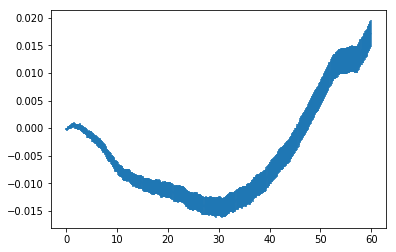

In [77]:


kalman_states = np.empty((number_of_timesteps, number_of_kalman_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_kalman_states)) * np.nan

I = np.identity(number_of_kalman_states)

# initialize state
mu = np.array([0, 0, 0, 0, 0, 0, np.pi/2])
P = Q# + R
for i in [0, 2, 4]:
    P[i, i] += 0 * GPS_RMS_ERROR ** 2
P[6, 6] = np.pi**2


for time_index in range(number_of_timesteps):
    # Kalman step
    
    theta = mu[6]

    u = np.concatenate((sensor_acceleration[time_index, :], sensor_rotation[time_index, :]))
    z = sensor_position[time_index, :]

    #print(z)
    
    # Predict
    mu_model = F @ mu + B(theta) @ u
    P = F @ P @ F.T + Q

    # Update
    y = z - H @ mu_model # pre-fit residual
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    #print(time_index, K)
    mu = mu_model + K @ y
    P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    y = z - H @ mu # post-fit residual

    
    
    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5
    
kalman_index = 1
plt.errorbar(t, (kalman_states[:, kalman_index]), kalman_errors[:, kalman_index])
#plt.plot(t, true_position)


In [65]:
K @ y

array([ 3.32141586e-01,  4.97699177e-10, -1.23719961e+00, -1.85388778e-09,
        1.15121330e+00,  1.72504118e-09,  0.00000000e+00])

In [66]:
B(np.pi)

array([[-5.0000000e-03, -6.1232340e-19,  0.0000000e+00,  0.0000000e+00],
       [-1.0000000e-01, -1.2246468e-17,  0.0000000e+00,  0.0000000e+00],
       [ 6.1232340e-19, -5.0000000e-03,  0.0000000e+00,  0.0000000e+00],
       [ 1.2246468e-17, -1.0000000e-01,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  5.0000000e-03,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e-01,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e-01]])

<ErrorbarContainer object of 3 artists>

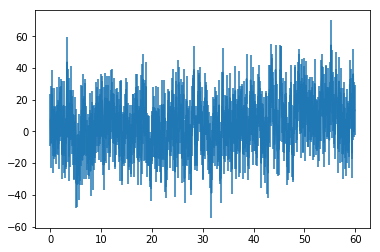

In [67]:
kalman_index = 0
plt.errorbar(t, (kalman_states[:, kalman_index]), kalman_errors[:, kalman_index])

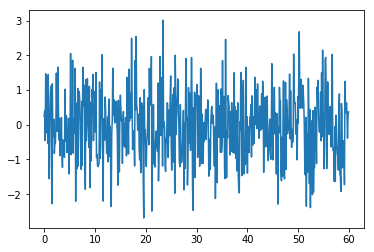

In [52]:
kalman_index = 6
plt.plot(t, sensor_position[:, 2])

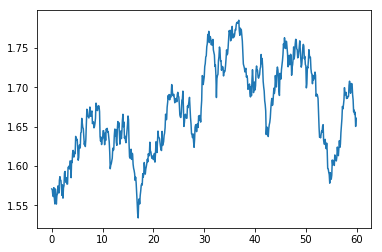

In [53]:
kalman_index = 6
plt.plot(t, (kalman_states[:, kalman_index]))

In [64]:
((I - K @ H) @ P @ (I - K @ H)).shape

(6, 6)

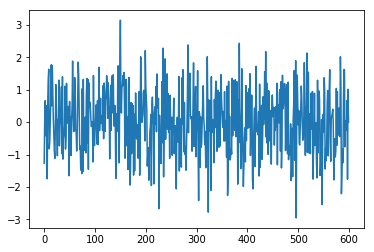

In [65]:
plt.plot(sensor_position[:, 1])

In [47]:
R.shape

(3,)